# Time Series Analysis Population of England 

In this notebook the [dataset](https://www.kaggle.com/datasets/axeltorbenson/population-of-england-since-1086?select=england_population.csv) from Kaggle, containing popoulation data of England over the last 1000 years, will be analyzed using Time Series techniques.

## **Import the required libraries**

In [116]:
# imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display
# ignore warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.1f}'.format
%matplotlib inline
plotsize = (13, 5)


import pmdarima as pm

## **Reading and understanding of the data**

This [dataset](https://www.kaggle.com/datasets/axeltorbenson/population-of-england-since-1086?select=england_population.csv) contains the just the total yearly population from England from the years 1086-2016. Since accurate measurements of the population of England has been conducted thourougly just since 1801(see [here](https://www.kaggle.com/datasets/axeltorbenson/population-of-england-since-1086?select=england_population.csv) or more information), most of the data are supposed to be estimations by the Bank of England. For simplicity just the past 250 years(1767-2016) will be analyzed, and  autoregressive integrated moving average (ARIMA) models will be used, to see how good they can predict the future population. 

Read data into dataframe.

In [117]:
data = pd.read_csv("england_population.csv")

In [118]:
data.head()

,year,population
0,1086,1710000
1,1087,1720000
2,1088,1730000
3,1089,1740000
4,1090,1750000


In [119]:
data.shape

(931, 2)

Verify that data is clean.

In [120]:
data.isna().value_counts()

year   population
False  False         931
dtype: int64

In [121]:
data.drop_duplicates(inplace=True)

Extract just the last 250 years and set years at the index.

In [122]:
data = data.tail(250)
data.set_index('year',inplace=True)

Plot the data.

<AxesSubplot:xlabel='year'>

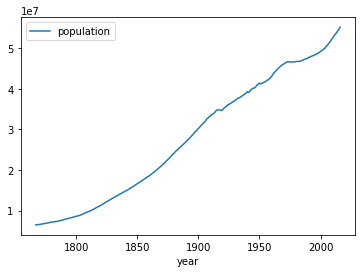

In [123]:
data.plot()

Looking at the curve one can see that from 1800-1900 the population grew steadily, but beginning from 1900 the grow rate slows down and becomes more uncertain.

Use [statsmodels.tsa.seasonal.STL](https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html) to decompose time series.

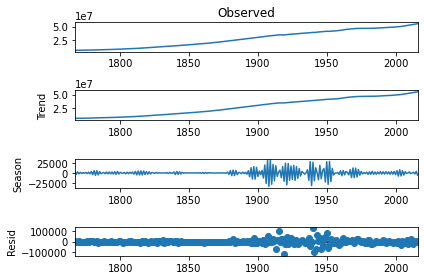

In [124]:
from statsmodels.tsa.seasonal import STL

res = STL(data,period=2).fit()
res.plot()
plt.show()

One can see that between 1900-1950 there is significant seasonality in the time series, probably also due to the two world wars in that time period.

Take a look at summary statistics of the data and a histogram.

In [125]:
data.describe()

,population
count,250.0
mean,"27,835,760.0"
std,"15,323,938.1"
min,"6,467,000.0"
25%,"12,945,750.0"
50%,"27,461,000.0"
75%,"41,633,500.0"
max,"55,219,000.0"


array([[<AxesSubplot:title={'center':'population'}>]], dtype=object)

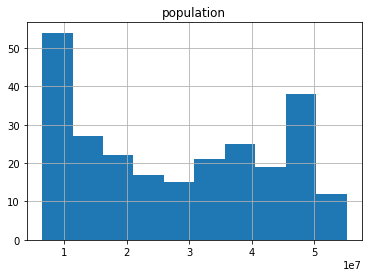

In [126]:
data.hist()

One can see that clearly the times series has no constant mean, so is not stationary.

To get a closer look at the variance, separate time series into chunks and see if there is heteroscedasticity.

In [127]:
chunks = np.split(np.array(data), indices_or_sections=10)
np.var(chunks, axis=1)

array([[1.65865878e+11],
       [6.41565190e+11],
       [1.56729912e+12],
       [2.17644255e+12],
       [4.55310768e+12],
       [4.99170903e+12],
       [2.09973973e+12],
       [2.72637875e+12],
       [2.90688458e+11],
       [5.10291019e+12]])

One can see there is clearly heteroscedasticity, also conduct a test for this purpose, see [here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.breakvar_heteroskedasticity_test.html#statsmodels.tsa.stattools.breakvar_heteroskedasticity_test).

In [128]:
from statsmodels.tsa.stattools import breakvar_heteroskedasticity_test

print('p-value: ',breakvar_heteroskedasticity_test(data)[1])

p-value:  3.349485629938015e-31


The null hypothesis was here that where is no heteroskedasticity, which can be rejected given the p-value.

Apply log transformation to numpy array of series, to remove heteroskedasticity, and test again.

In [129]:
data2 = np.array(data['population'])
data_log = np.log(data2)
print('p-value: ',breakvar_heteroskedasticity_test(data_log)[1])

p-value:  0.41014286976219405


Given the p-value, the null hypothesis cannot be rejected, and no where is less heteroskedasticity.

Take a look athe the autocorrelation.

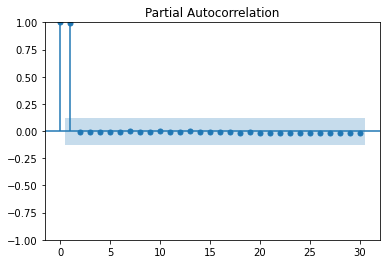

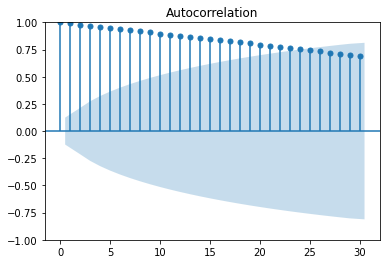

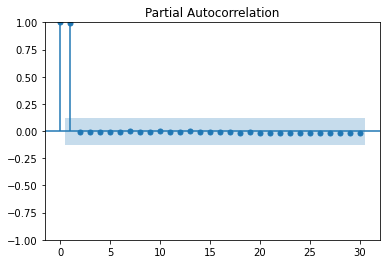

In [130]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(data,lags=30)
plot_pacf(data,lags=30)

One can see that there is significant autocorrolation for the first 20 legs and the autocorrolation tends slowly to zero, so AR model with p=2 may be appropiate looking at the partial autocorolloation plot.

Conduct Augmented Dickey-Fuller Test to see whether log transformed data is stationary.

In [131]:
from statsmodels.tsa.stattools import adfuller

print('p-value: ', adfuller(data_log)[1])

p-value:  0.1138948354522557


The nullhypothesis was that the transformed series is non-stationary, which can be rejected as expected, given the autocorrolation.

Try to remove autocorollation y differencing and test again.

In [132]:
data_diff = data_log[1:] - data_log[:-1] 

In [133]:
print('p-value: ', adfuller(data_diff)[1])

p-value:  0.3709152928104722


Still nullhypothesis of non-stationarity cannot be rejected to difference again.

In [134]:
data_diff2 = data_diff[1:] - data_diff[:-1] 

In [135]:
print('p-value: ', adfuller(data_diff2)[1])

p-value:  1.1359430247560382e-18


No data is stationary. If one runs the differencing with the original data, the p-value is smaller, but one also needs to steps of differencing to make it stationary.

Plot the two times differenced log data.

<AxesSubplot:>

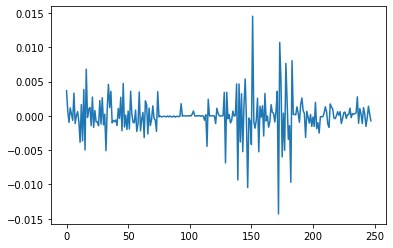

In [136]:
pd.Series(data_diff2).plot()

Also plot the original data two times differenced.

<AxesSubplot:>

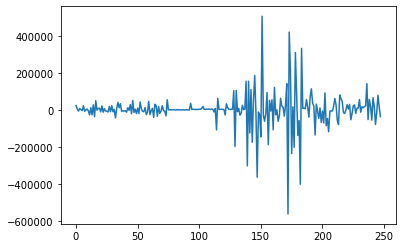

In [137]:
data_diff = data2[1:] - data2[:-1]
data_diff2 = data_diff[1:] - data_diff[:-1] 
pd.Series(data_diff2).plot()

Now look how good ARIMA models can predict the future population. Use a pdarima to automatically find the best model.

Define function to measure the error on test set.

In [138]:
def mape(df_cv):
    return abs(df_cv.actual - df_cv.fcst).sum() / df_cv.actual.sum()

First try with the orginal data without log transformation, with test set the last 50 observations. Note the differencing will be made automatically by the ARIMA model.

In [139]:
stepwise_model = pm.auto_arima(data2[:-50],
                           trace=True,max_order=None,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=5119.104, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=5121.495, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=5125.258, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5121.057, Time=0.00 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.330 seconds
5119.103536538678


As expected the data has been two times differenced, but the p and q value are both zero.

Look how good the predictions are.

In [140]:
data_predict = np.concatenate((data2[:-50].astype(int),stepwise_model.predict(n_periods=50).astype(int)))

In [141]:
data3 = pd.DataFrame({'actual':data2,'fcst':data_predict})

0.027001526094491402

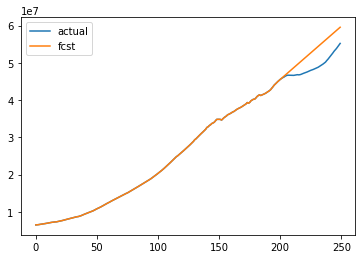

In [142]:
data3.plot()
mape(data3)

One can see that the predictions are not very good, the model does not pick up the trend of the reduced growth rate.

Now try the same with the log transformed data.

In [143]:
stepwise_model = pm.auto_arima(data_log[:-50],
                           trace=True,max_order=None,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-1790.247, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-1735.925, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-1769.908, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-1787.566, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-1789.681, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-1790.232, Time=0.14 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-1760.349, Time=0.28 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-1790.628, Time=0.13 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-1791.219, Time=0.09 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-1793.469, Time=0.14 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-1792.205, Time=0.06 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=-1791.179, Time=0.27 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=-1788.392, Time=0.28 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-1791.458, Time=0.24 sec

Best model:  ARIMA

In [144]:
data_predict = np.concatenate((data2[:-50].astype(int),np.exp(stepwise_model.predict(n_periods=50)).astype(int)))

In [145]:
data3 = pd.DataFrame({'actual':data2,'fcst':data_predict})

<AxesSubplot:>

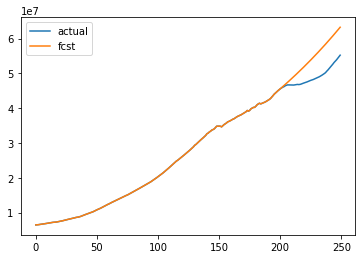

In [146]:
mape(data3)
data3.plot()

The automatic search put out a model with two times differenced and p=0 and q=3, but the predictions are still worse compared to the last model.

## Conclusion

The ARIMA models do not deliver good results predicting the future population, which may be due to the other factors influencing  the popolution like fertility rate or migration not covered by the model. Considering these various influecing variables one may attain better predictions.